# Import required libraries

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [152]:
old_m16_path = 'tactics/data/stats/metrics_test_t_m1600_old.csv'
none_m16_path = 'tactics/data/stats/metrics_test_t_m1600_none.csv'
prec_m16_path = 'tactics/data/stats/metrics_test_t_m1600_prec.csv'
rec_m16_path = 'tactics/data/stats/metrics_test_t_m1600_rec.csv'
new_m16_path = 'tactics/data/stats/metrics_test_t_m1600_all.csv'

old_sf14_path = 'tactics/data/stats/metrics_test_t_sf14_old.csv'
none_sf14_path = 'tactics/data/stats/metrics_test_t_sf14_none.csv'
prec_sf14_path = 'tactics/data/stats/metrics_test_t_sf14_prec.csv'
rec_sf14_path = 'tactics/data/stats/metrics_test_t_sf14_rec.csv'
new_sf14_path = 'tactics/data/stats/metrics_test_t_sf14_all.csv'

old_m16_raw = pd.read_csv(old_m16_path)
none_m16_raw = pd.read_csv(none_m16_path)
rec_m16_raw = pd.read_csv(rec_m16_path)
new_m16_raw = pd.read_csv(new_m16_path)

old_sf14_raw = pd.read_csv(old_sf14_path)
none_sf14_raw = pd.read_csv(none_sf14_path)
prec_sf14_raw = pd.read_csv(prec_sf14_path)
rec_sf14_raw = pd.read_csv(rec_sf14_path)
new_sf14_raw = pd.read_csv(new_sf14_path)

In [89]:
old_m16_raw.head()

,match,num_suggestions,correct_move,tactic_text,move,position,tactic_ground_div,tactic_ground_avg
0,1,1.0,1.0,ground,c1b2,r3k2r/bpp1n1pp/p1np4/P3p3/1P6/2P1P3/3P1PPP/RNB...,0.0,0.0
1,1,1.0,0.0,random,c1b2,r3k2r/bpp1n1pp/p1np4/P3p3/1P6/2P1P3/3P1PPP/RNB...,21.0,21.0
2,1,1.0,0.0,sf14,c1b2,r3k2r/bpp1n1pp/p1np4/P3p3/1P6/2P1P3/3P1PPP/RNB...,2.0,2.0
3,1,1.0,0.0,maia_1600,c1b2,r3k2r/bpp1n1pp/p1np4/P3p3/1P6/2P1P3/3P1PPP/RNB...,5.0,5.0
4,0,NaN,NaN,"f(A,B,C):-legal_move(B,C,A),attacks(B,D,A),beh...",c1b2,r3k2r/bpp1n1pp/p1np4/P3p3/1P6/2P1P3/3P1PPP/RNB...,NaN,NaN


## Generate graphs

In [153]:
def calculate_metrics(df): # TODO: refactor this and the method in analysis.py
    agg = df.groupby('tactic_text').aggregate(np.nansum).reset_index()
    agg['avg_tactic_ground_avg'] = agg['tactic_ground_avg'] / agg['match']
    agg['coverage'] = agg['match'] / df.groupby(['position', 'move']).ngroups
    agg['accuracy'] = agg['correct_move'] / agg['match']
    return agg

In [91]:
def generate_frequency_graph(df, metric_fname: str, title: str='?', xlabel: str=None, bins: int=20, left: int=0, right=None):
    mask = df['tactic_text'].isin(['ground', 'sf14', 'maia_1600', 'random'])
    df_masked = df[~mask]
    plt.hist(df_masked[metric_fname], bins=bins) # exclude default tactics from histogram
    plt.axvline(df[df['tactic_text'] == "random"][metric_fname].values, linestyle='dashed', color='blue', label='random move tactic')
    plt.axvline(df[df['tactic_text'] == "ground"][metric_fname].values, linestyle='dashed', color='green', label='ground move tactic')
    plt.axvline(df[df['tactic_text'] == "sf14"][metric_fname].values, linestyle='dashed', color='red', label='sf14 move tactic')
    plt.axvline(df[df['tactic_text'] == "maia_1600"][metric_fname].values, linestyle='dashed', color='magenta', label='maia-1600 move tactic')
    plt.title(f'Histogram of {title}')
    plt.xlabel(xlabel if xlabel else metric_fname)
    plt.ylabel('Frequency')
    plt.xlim(left=left, right=right)
    plt.legend(loc=1)
    plt.show()

In [154]:
old_m16 = calculate_metrics(old_m16_raw)
none_m16 = calculate_metrics(none_m16_raw)
prec_m16 = calculate_metrics(prec_sf14_raw)
rec_m16 = calculate_metrics(rec_m16_raw)
new_m16 = calculate_metrics(new_m16_raw)

old_sf14 = calculate_metrics(old_sf14_raw)
none_sf14 = calculate_metrics(none_sf14_raw)
prec_sf14 = calculate_metrics(prec_sf14_raw)
rec_sf14 = calculate_metrics(rec_sf14_raw)
new_sf14 = calculate_metrics(new_sf14_raw)

In [155]:
random_tactic = new_m16[new_m16['tactic_text'] == "random"]
ground_tactic = new_m16[new_m16['tactic_text'] == "ground"]
m1600_tactic = new_m16[new_m16['tactic_text'] == "maia_1600"]
sf14_tactic = new_m16[new_m16['tactic_text'] == "sf14"]

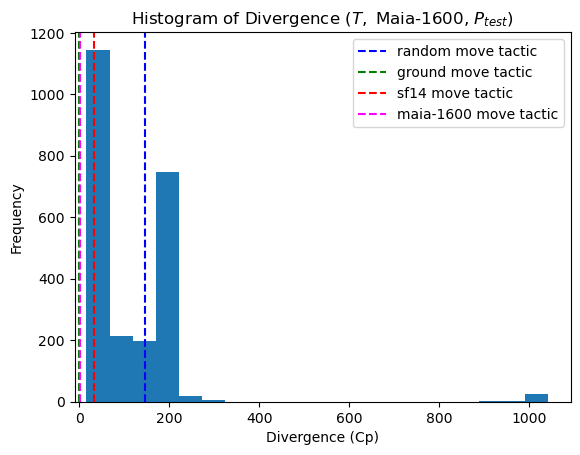

In [93]:
generate_frequency_graph(new_m16, 'avg_tactic_ground_avg', "Divergence $(T,$ Maia-1600, $P_{test})$", "Divergence (Cp)", left=-10)

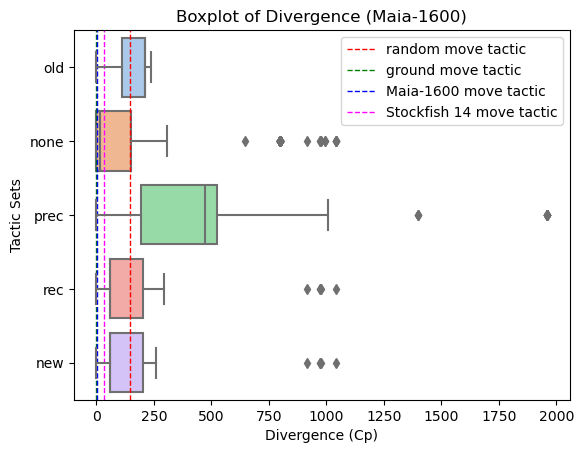

In [156]:
data = pd.DataFrame({
    "old": old_m16['avg_tactic_ground_avg'],
    "none": none_m16['avg_tactic_ground_avg'],
    "prec": prec_m16['avg_tactic_ground_avg'],
    "rec": rec_m16['avg_tactic_ground_avg'],
    "new": new_m16['avg_tactic_ground_avg'],
})

rand_line = plt.axvline(random_tactic['avg_tactic_ground_avg'].values, linestyle='dashed', color='red', label='random move tactic', linewidth=1)
ground_line = plt.axvline(ground_tactic['avg_tactic_ground_avg'].values, linestyle='dashed', color='green', label='ground move tactic', linewidth=1)
m1600_line = plt.axvline(m1600_tactic['avg_tactic_ground_avg'].values, linestyle='dashed', color='blue', label='Maia-1600 move tactic', linewidth=1)
sf14_line = plt.axvline(sf14_tactic['avg_tactic_ground_avg'].values, linestyle='dashed', color='magenta', label='Stockfish 14 move tactic', linewidth=1)

# ax = data[["old", "none", "prec", "rec", "new"]].plot(kind='box', title='Box Plot of Divergences (Maia-1600) of Tactics Learned', vert=False)
sns.boxplot(y="variable", x="value", data=pd.melt(data[["old", "none", "prec", "rec", "new"]]), palette='pastel')
plt.xlabel('Divergence (Cp)')
plt.ylabel('Tactic Sets')
plt.title('Boxplot of Divergence (Maia-1600)')
plt.legend(loc=1)
plt.show()

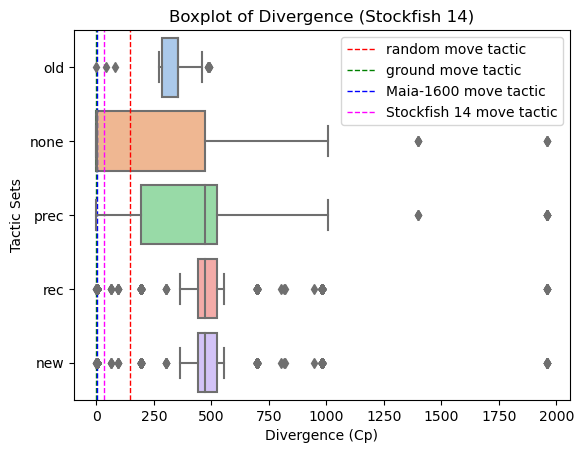

In [157]:
data = pd.DataFrame({
    "old": old_sf14['avg_tactic_ground_avg'],
    "none": none_sf14['avg_tactic_ground_avg'],
    "prec": prec_sf14['avg_tactic_ground_avg'],
    "rec": rec_sf14['avg_tactic_ground_avg'],
    "new": new_sf14['avg_tactic_ground_avg'],
})

rand_line = plt.axvline(random_tactic['avg_tactic_ground_avg'].values, linestyle='dashed', color='red', label='random move tactic', linewidth=1)
ground_line = plt.axvline(ground_tactic['avg_tactic_ground_avg'].values, linestyle='dashed', color='green', label='ground move tactic', linewidth=1)
m1600_line = plt.axvline(m1600_tactic['avg_tactic_ground_avg'].values, linestyle='dashed', color='blue', label='Maia-1600 move tactic', linewidth=1)
sf14_line = plt.axvline(sf14_tactic['avg_tactic_ground_avg'].values, linestyle='dashed', color='magenta', label='Stockfish 14 move tactic', linewidth=1)

# ax = data[["old", "none", "prec", "rec", "new"]].plot(kind='box', title='Box Plot of Divergences (Maia-1600) of Tactics Learned', vert=False)
sns.boxplot(y="variable", x="value", data=pd.melt(data[["old", "none", "prec", "rec", "new"]]), palette='pastel')
plt.xlabel('Divergence (Cp)')
plt.ylabel('Tactic Sets')
plt.title('Boxplot of Divergence (Stockfish 14)')
plt.legend(loc=1)
plt.show()

In [159]:
print('old m16')
print(old_m16.mean(), old_m16.std())

print('none m16')
print(none_m16.mean(), none_m16.std())

print('prec m16')
print(prec_m16.mean(), prec_m16.std())

print('rec m16')
print(rec_m16.mean(), rec_m16.std())

print('new m16')
print(new_m16.mean(), new_m16.std())

print('old sf14')
print(old_sf14.mean(), old_sf14.std())

print('none sf14')
print(none_sf14.mean(), none_sf14.std())

print('prec sf14')
print(prec_sf14.mean(), prec_sf14.std())

print('rec sf14')
print(rec_sf14.mean(), rec_sf14.std())

print('new sf14')
print(new_sf14.mean(), new_sf14.std())

old m16
match                      4.461356
num_suggestions           41.369798
correct_move               0.661118
tactic_ground_div        468.522711
tactic_ground_avg        732.285322
avg_tactic_ground_avg    174.484153
coverage                   0.446136
accuracy                   0.120367
dtype: float64 match                      1.586773
num_suggestions           50.462433
correct_move               0.863560
tactic_ground_div        137.104788
tactic_ground_avg        262.169046
avg_tactic_ground_avg     48.693434
coverage                   0.158677
accuracy                   0.130892
dtype: float64
none m16
match                      3.131165
num_suggestions            3.131165
correct_move               0.622764
tactic_ground_div        499.567480
tactic_ground_avg        499.567480
avg_tactic_ground_avg    103.621904
coverage                   0.313117
accuracy                   0.488578
dtype: float64 match                      3.448117
num_suggestions            3.448117
co

/tmp/ipykernel_1047/938486257.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(old_m16.mean(), old_m16.std())
/tmp/ipykernel_1047/938486257.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(none_m16.mean(), none_m16.std())
/tmp/ipykernel_1047/938486257.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(prec_m16.mean(), prec_m16.std())
/tmp/ipykernel_1047/938486257.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None

match                      5.097957
num_suggestions            5.097957
correct_move               0.371922
tactic_ground_div        759.392876
tactic_ground_avg        759.392876
avg_tactic_ground_avg    106.023248
coverage                   0.509796
accuracy                   0.061763
dtype: float64 match                      3.548310
num_suggestions            3.548310
correct_move               0.556049
tactic_ground_div        878.662832
tactic_ground_avg        878.662832
avg_tactic_ground_avg     84.904761
coverage                   0.354831
accuracy                   0.118127
dtype: float64
old sf14
match                       4.461356
num_suggestions            41.369798
correct_move                0.659929
tactic_ground_div         913.120047
tactic_ground_avg        1496.396215
avg_tactic_ground_avg     337.564711
coverage                    0.446136
accuracy                    0.120248
dtype: float64 match                      1.586773
num_suggestions           50.462433
co

/tmp/ipykernel_1047/938486257.py:17: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(old_sf14.mean(), old_sf14.std())
/tmp/ipykernel_1047/938486257.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(none_sf14.mean(), none_sf14.std())
/tmp/ipykernel_1047/938486257.py:23: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(prec_sf14.mean(), prec_sf14.std())
/tmp/ipykernel_1047/938486257.py:26: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_

match                       5.097957
num_suggestions             5.087480
correct_move                0.366160
tactic_ground_div        2402.278680
tactic_ground_avg        2402.278680
avg_tactic_ground_avg     443.763048
coverage                    0.509796
accuracy                    0.061157
dtype: float64 match                       3.548310
num_suggestions             3.548584
correct_move                0.528563
tactic_ground_div        1703.192183
tactic_ground_avg        1703.192183
avg_tactic_ground_avg     263.924455
coverage                    0.354831
accuracy                    0.116919
dtype: float64


# Analyze Position Features

In [ ]:
df['pos_move'] = df['position'] + "," + df['move']

In [ ]:
df2 = df.groupby('pos_move')
agg = df2.aggregate(np.sum)
agg

In [ ]:
plt.hist(agg['exec_time'], bins=100)
plt.title('Histogram of Execution Time $(T_{1600},$ Stockfish 14, $P_{valid})$')
plt.xlabel('Execution Time (s)')
plt.ylabel('Frequency')

In [ ]:
high_exec = agg[agg['exec_time'] > 100]
high_exec = high_exec.sort_values(by = ['exec_time'], ascending = [False])
high_exec

In [ ]:
low_exec = agg[agg['exec_time'] <= 100]
plt.hist(low_exec['exec_time'], bins=100)
plt.title('Histogram of Execution Time $(T_{1600},$ Stockfish 14, $P_{valid})$')
plt.xlabel('Execution Time (s)')
plt.ylabel('Frequency')

In [ ]:
num_exs = [1, 5, 20, 100]
time_vals = [27.5, 60 + 33, 60 * 6 + 33, 33 * 60 + 8]
num_tactics = [9, 117, 469, 837]

In [ ]:
plt.plot(num_exs, time_vals)
plt.xlabel('Number of train examples')
plt.ylabel('Execution time (s)')
plt.show()

In [ ]:
plt.plot(num_exs, num_tactics)
plt.xlabel('Number of train examples')
plt.ylabel('Number of tactics learned')
plt.show()

In [ ]:
plt.plot(num_tactics, time_vals)
plt.xlabel('Number of tactics learned')
plt.ylabel('Execution time (s)')
plt.show()

# Calculate Dataset Metrics

In [ ]:
from collections import Counter

total_games = 0
valid_elo = 0
total_pos = 0
total_elo = 0
game_count = Counter()

pgn_path = 'tactics/data/lichess_db_standard_rated_2013-01.pgn'

In [ ]:
offsets = []
handle = open(pgn_path)
header = chess.pgn.read_headers(handle)

In [ ]:
header.get('Termination')


In [ ]:
import chess.pgn

with open(pgn_path) as pgn:
    while game := chess.pgn.read_game(pgn):
        total_games += 1
        white_elo = game.headers['WhiteElo']
        black_elo = game.headers['BlackElo']
        if '?' not in white_elo and '?' not in black_elo:
            total_elo += int(white_elo)
            total_elo += int(black_elo)
            valid_elo += 1
        game_count[game.headers['Event']] += 1

In [ ]:
print('Total games', total_games)
avg_elo = total_elo / (2 * valid_elo)
print('Average ELO', avg_elo)

In [ ]:
variance = 0

with open(pgn_path) as pgn:
    while game := chess.pgn.read_game(pgn):
        total_games += 1
        white_elo = game.headers['WhiteElo']
        black_elo = game.headers['BlackElo']
        if '?' not in white_elo and '?' not in black_elo:
            variance += (int(white_elo) - avg_elo) ** 2
            variance += (int(black_elo) - avg_elo) ** 2
        game_count[game.headers['Event']] += 1

In [ ]:
import math

print('SD', math.sqrt(variance / valid_elo))

# Test Evaluation

In [ ]:
import chess
import chess.engine
from tactics.util import *

board = chess.Board('r1bqkb1r/ppp1pnpp/3p4/7Q/8/3B4/PPP2PPP/RNB2RK1 w kq - 0 10')
move_names = [
    'b1c3',
    'c1g5',
    'd3c4',
    'f1e1'
]
moves = [chess.Move.from_uci(move_name) for move_name in move_names]
engine_path = get_lc0_cmd(LC0, MAIA_1600) + ['--nncache=0']
#engine_path = STOCKFISH
mate_score = 2000
n = 10

In [ ]:
with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:
    tmp_analysis = engine.analyse(board, limit=chess.engine.Limit(nodes=1), multipv=n, game=object())
    top_results = [(root['pv'][0], root['score'].relative.score(mate_score=mate_score)) for root in tmp_analysis]
    top_n_results = top_results[:n]
top_n_results

In [ ]:
with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:
    all_evals = get_evals(engine, board, board.legal_moves)
    all_evals.sort(key=lambda eval: eval[1], reverse=True)
    top_n_results = all_evals[:n]
top_n_results

In [ ]:
def get_evals(engine: chess.engine.SimpleEngine, board: chess.Board, suggestions: List[chess.Move], mate_score: int=2000) -> List[Tuple[chess.Move, int]]:
    "Obtain engine evaluations for a list of moves in a given position"

    evals = []
    for move in suggestions:
        tmp_board = chess.Board(board.fen())
        tmp_board.push(move)
        if tmp_board.outcome() is not None:
            move_score = mate_score if tmp_board.is_checkmate() else -mate_score
            evals.append((move, move_score))
            continue
        limit = chess.engine.Limit(nodes=1)
        # prev_eval = engine.analyse(board, limit=limit, game=object()) # https://stackoverflow.com/a/66251120
        # print(prev_eval) 
        curr_eval = engine.analyse(tmp_board, limit=limit, game=object())
        print(curr_eval)
        orig_turn = board.turn
        if 'pv' in curr_eval:
            # prev_score = prev_eval['score'].pov(orig_turn)
            curr_score = curr_eval['score'].pov(orig_turn)
            move_score = curr_score.score(mate_score=mate_score)
            evals.append((move, move_score))
    return evals

In [ ]:
with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:
    evals = get_evals(engine, board, moves)
evals